# Dog Identification App using CNNs

## Overview
Student provides a high-level overview of the project. Background information such as the problem domain, the project origin, and related data sets or input data is provided.

## Problem Statement
The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.

## Metrics
Metrics used to measure the performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.

For example, explain why you want to use the accuracy score and/or F-score to measure your model performance in a classification problem,

<hr>

# Table of Contents

* Part 0 - [Setup](#Setup)
* Part 1 - [Detect Humans](#Part-1---Detect-Humans)
* Part 2 - [Detect Dogs](#Part-2---Detect-Dogs)
* Part 3 - [Create a CNN to Classify Dog Breeds (from Scratch)](#Part-3---Create-a-CNN-to-Classify-Dog-Breeds-(from-Scratch))
* Part 4 - [Use a CNN to Classify Dog Breeds (using Transfer Learning)](#Part-4---Use-a-CNN-to-Classify-Dog-Breeds-(using-Transfer-Learning))
* Part 5 - [Create a CNN to Classify Dog Breeds (using Transfer Learning)](#Part-5---Create-a-CNN-to-Classify-Dog-Breeds-(using-Transfer-Learning))
* Part 6 - [Write your Algorithm](#Part-6---Write-your-Algorithm)
* Part 7 - [Test your Algorithm](#Part-7---Test-your-Algorithm)
<hr>

# Setup

## Import Libraries

In [1]:
# To import Dog dataset
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# To import Human dataset
import random; random.seed(8675309)

# To detect Humans
import cv2
import matplotlib.pyplot as plt

# To preprocess data
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# To create a model architecture and train the model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 

# To create a dataframe with results
import pandas as pd

## Load Data

### Load Dog Dataset

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dog_images/train')
valid_files, valid_targets = load_dataset('dog_images/valid')
test_files, test_targets = load_dataset('dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Load Human Dataset

In [3]:
# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13251 total human images.


<hr>

# Part 1 - Detect Humans

Before using any of the face detectors, it is standard procedure to convert the image to grayscale. The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.

In [4]:
# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [5]:
# Load color (BGR) image
img = cv2.imread(human_files[42])
# Convert BGR to grayscale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Find faces in image
faces = face_cascade.detectMultiScale(gray)
# Print number of faces deteceted in the image
print(f'Number of faces detected: {len(faces)}')

Number of faces detected: 1


In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. 

The first two entries in the array (extracted in the below code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two enries in the array (extracted here as `w` and `y`) specifiy the width and height of the box.

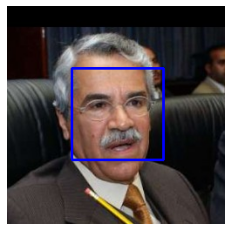

In [6]:
# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with the bounding bow
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

## Write a Human Face Detector
We can use this procedure to write a funciton that returns `True` if a human face is detected in an image and `False` otherwise. This function, aptly name `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
def face_detector(img_path):
    """
    Given an image path file, it returns True if a human face
    is detected and False otherwise
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [9]:
def performance_detector(detector, files:list, category:str):
    """It runs a detector function and prints results to check performance
    Arguments:
        detector: (function) - a function that returns True/False if detects a certain category
        files: (list) - image path files to predict
        category: (str) - whether there are 'human' photos or 'dog' photos
    Returns:
        None
    """
    performance = [detector(file) for file in files]
    
    if detector == face_detector:
        obj = 'human face'
    elif detector == dog_detector:
        obj = 'dog'
        
    print(f'In the subset of {category} images, {sum(performance)}% have a detected {obj}')

In [10]:
performance_detector(detector=face_detector, files=human_files_short, category='human')
performance_detector(detector=face_detector, files=dog_files_short, category='dog')

In the subset of human images, 99% have a detected human face
In the subset of dog images, 12% have a detected human face


<br>

**Question**

This algorithmic choice necessitates communicating to futur users that we only accept human images when they provide a clear view of a face. Is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

**Answer**

I think it is reasonable to expect that if a user wants to try the application they present a photo with a clear view of a face. They are not forced to do this, but if they want a more accurate and pleasant experience, they would know that they should present a photo as describe above.

<hr>

# Part 2 - Detect Dogs
In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.

The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.

ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [11]:
# https://stackoverflow.com/questions/54682539/i-am-not-able-to-import-resnet-from-keras-applications-module
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

## Preprocess the data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as 4D tensor) as input, with shape:
$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` corresponds to the number of rows, columns and channels for each image, respectively.

In [12]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

The `path_to_tensor` function above takes a string-value file path to a color image as input and returns a 4D tensor suitable for supplying to a Kears CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processiing a single image (or sample), the returned tensor will alwats have shape:
$$
(1, 224,  224, 3)
$$


In [13]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

The `paths_to_tesnor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape:
$$
(\text{nb_samples}, 224, 224,3)
$$
Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

## Making Predictions with ResNet-50
Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels.

All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$) and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input` ([code here](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py))

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th  ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

In [14]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

## Dog Detector
While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dicionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector
* What percentage of the images in `human_files_short` have a detected dog?
* What percentage of the images in `dog_files_short` have a detected dog?

In [16]:
performance_detector(detector=dog_detector, files=human_files_short, category='human')
performance_detector(detector=dog_detector, files=dog_files_short, category='dog')

In the subset of human images, 0% have a detected dog
In the subset of dog images, 100% have a detected dog


<hr>

# Part 3 - Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we build a CNN that classifies dog breeds (from scratch!).

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">


## Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:07<00:00, 111.52it/s]


## Model Architecture

#### Question: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.

CNNs use locally connected layers (as opposed to MLPs that use densely connected layers). These layers are generally :
- **Convolutional Layers** that detect regional patterns in an image using filters (more complex images need more filters)
- **Pooling Layers**, often between the convolutional layers, that help decrease the dimensionality and thus decrease risk of overfitting

Moreover, the first layer must include the size of the input, and the last layer must be fully connected layer with one node per category (in our case 133).

Following this logic, the chosen architecture mixes convoluation layers and pooling layers, adds a dropout layer to avoid overfitting and a flatter layer to flatten the input, and finally applies two fully connected layers at the end.

All layers, as usual, follow a relu activation function, besides the very last year that uses a softmax layer to ouput probabilities for each category.

In [18]:
model = Sequential([
    Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu', 
                 input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    
    Dropout(rate=0.33, seed=42),
    
    Flatten(),
    
    Dense(266, activation='relu'),
    Dense(133, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

### Compile the Model

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [20]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=25, callbacks=[checkpointer], verbose=1)

Epoch 1/10
268/268 [==============================] - ETA: 0s - loss: 4.8196 - accuracy: 0.0207
Epoch 1: val_loss improved from inf to 4.53790, saving model to saved_models\weights.best.from_scratch.hdf5
268/268 [==============================] - 96s 352ms/step - loss: 4.8196 - accuracy: 0.0207 - val_loss: 4.5379 - val_accuracy: 0.0371
Epoch 2/10
268/268 [==============================] - ETA: 0s - loss: 4.1913 - accuracy: 0.0811
Epoch 2: val_loss improved from 4.53790 to 4.43575, saving model to saved_models\weights.best.from_scratch.hdf5
268/268 [==============================] - 95s 353ms/step - loss: 4.1913 - accuracy: 0.0811 - val_loss: 4.4358 - val_accuracy: 0.0515
Epoch 3/10
268/268 [==============================] - ETA: 0s - loss: 3.3934 - accuracy: 0.2127
Epoch 3: val_loss improved from 4.43575 to 4.37794, saving model to saved_models\weights.best.from_scratch.hdf5
268/268 [==============================] - 96s 358ms/step - loss: 3.3934 - accuracy: 0.2127 - val_loss: 4.3779 -

### Load the Model with the Best Validation Loss

In [21]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [22]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.2871%


<hr>

# Part 4 - Use a CNN to Classify Dog Breeds (using Transfer Learning)

To reduce training time without sacrificin accuracy, in this part we use transfer learning to train our CNN.

## Obtain Bottleneck Features

In [23]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

## Model Architecture
The model uses the pre-trained VGG-16 model as a fixed feature extractor, where the last convoluational output of VGG-16 is fed as input to the modl. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax activation function.

In [24]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [25]:
print(VGG16_model)

## Compile the Model

In [26]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the Model

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
309/334 [==========================>...] - ETA: 0s - loss: 8.1604 - accuracy: 0.2193
Epoch 1: val_loss improved from inf to 3.97371, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 7.7930 - accuracy: 0.2373 - val_loss: 3.9737 - val_accuracy: 0.4347
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 2.1860 - accuracy: 0.5967
Epoch 2: val_loss improved from 3.97371 to 2.36475, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 2.1860 - accuracy: 0.5967 - val_loss: 2.3647 - val_accuracy: 0.6000
Epoch 3/20
310/334 [==========================>...] - ETA: 0s - loss: 1.1919 - accuracy: 0.7419
Epoch 3: val_loss improved from 2.36475 to 2.24060, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.1971 - accuracy: 0.7431 - val_loss: 2.2406 - val_accuracy: 0.6287
Epoch 4/

## Load the Model with the Best Validation Loss

In [28]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

## Test the Model

In [29]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.0861%


## Predict Dog Breed with the Model

In [30]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [31]:
train_files[0]

'dog_images/train\\095.Kuvasz\\Kuvasz_06442.jpg'

In [32]:
VGG16_predict_breed(train_files[0])

'.Kuvasz'

<hr>

# Part 5 - Create a CNN to Classify Dog Breeds (using Transfer Learning)

Now we will use transfer learning to create a CNN that can identify dog breed from images.  

In Part 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.  

Udacity has pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [33]:
def extract_bottleneck_features(network):
    """Obtain bottleneck features from another pre-trained CNN.
    Arguments:
        network: (str) - one of 'VGG19', 'ResNet50', 'InceptionV3', 'Xception'
    Returns:
        train, valid, test: (np array) containing resp. train, validation and test sets"""
    bottleneck_features = np.load(f'bottleneck_features/Dog{network}Data.npz')
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    
    return train, valid, test

## Model Architecture
Create a CNN to classify dog breed.

**Outline the steps you took to get to the final CNN architecture and the reasoning at each step. Describe why you think the architecture is suitable for the current problem**

When using Transfer Learning, two important things to check before choosing a model architecture:
* Is our data similar to the data used for trainining the pre-trained model?
* How big is our dataset?

In this case, the data we used here is similar to the data used for training the pre-trained CNN. Moreover, our dataset is rather small. These two factors indicate that our model architecture should largely include the pre-trained model as is, but without the end of the neural network which should be replaced by a new fully connected layer.

In addition, to reduce training time, a GAP (Global Average Pooling) layer could be included in between. The training process will be rather short and fast as it will only include the GAP layer and the Dense layer, thus adding a Dropout layer does not seem necessary.

Thus, our model architecture would be the same as before, only the input would change to adapt to the new pre-trained models. 

Knowing that this architecture obtained almost 70% accuracy using the VGG-16 model, this seems like a suitable architecture for our task.

In [34]:
def model_architecture(trained_model):    
    """Model architecture using transfer learning then adding
    a GAP layer for dimensionality reduction and a fully connected layer 
    with one node for each dog category (133)
    Arguments:
        trained_model: pre-trained CNN model
    Returns:
        model: new model using transfer learning
    """
    model = Sequential([
        GlobalAveragePooling2D(input_shape=trained_model.shape[1:]),
        Dense(133, activation='softmax')
    ])

    print(model.summary())
        
    return model

## Compile the Model

In [35]:
def compile_model(model):
    """Compiles the model"""
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

## Train the Model
Train the model using checkpointing to save the model that attains the best validation loss.

In [36]:
def train_model(network, model, train, valid, n_epochs=20, batch_size=20):
    """Trains the model and keeps a checkpoint with best model
    Arguments:
        network: (str) - pre-trained model name
        model: (keras object) - model to train
        train, valid: training and validation data for the model
        n_epochs: (int) - number of epochs
        batch_size: (int) - size of each batch
    Returns:
        model: (keras object) - trained model"""
    checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{network}.hdf5', 
                               verbose=1, save_best_only=True)

    model.fit(train, train_targets, 
          validation_data=(valid, valid_targets),
          epochs=n_epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
    
    return model

## Load the Model with the Best Validation Loss

In [37]:
def load_weights(model, network):
    """Loads the weight of the given model"""
    model.load_weights(f'saved_models/weights.best.{network}.hdf5')
    
    return model

## Test the Model
Try out the model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [38]:
def test_model(model, test):
    """Test the model's accuracy"""
    # get index of predicted dog breed for each image in test set
    predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
    return test_accuracy

## Comparing models

In [39]:
def run_model(network):
    """Run each step of the training process: extracting features 
    of pre-trained models, creating a model architecture, compiling
    the model, trains the model, loads the weight, then tests the model
    Arguments:
        network: (str) - pre-trained CNN model name
    Returns:
        model: (keras object) - trained new model
        accuracy: (float) - accuracy of the model on test data"""
    train, valid, test = extract_bottleneck_features(network=network)
    model = model_architecture(train)
    model = compile_model(model)
    model = train_model(network, model, train, valid)
    model = load_weights(model, network)
    accuracy = test_model(model, test)
    
    return model, accuracy

Below we test the different pre-trained models.

*Note that we do not test ResNet-50 as it had relatively low accuracy and it gave errors when trying to predict dog breed.*

In [40]:
networks = ['VGG19', 'InceptionV3', 'Xception']
models = []
models_performance = []

for network in networks:
    model, accuracy = run_model(network)
    
    # Save trained models & accuracy of each model
    models.append(model)
    models_performance.append(accuracy)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
329/334 [============================>.] - ETA: 0s - loss: 7.1926 - accuracy: 0.2582
Epoch 1: val_loss improved from inf to 3.22626, saving model to saved_models\weights.best.VGG19.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 7.1244 - accuracy: 0.2621 - val_loss: 3.2263 - val_accuracy: 0.4683
Epoch 2/20
321/334 [===========================

In [41]:
results = pd.DataFrame(models_performance, index=networks, columns=['Accuracy'])
results

,Accuracy
VGG19,71.052632
InceptionV3,79.545455
Xception,84.210526


## Predict Dog Breed with the Model

In [42]:
def predict_dog_breed(model, img_path, extract_function):
    """Predicts the dog breed for a given image
    Arguments:
        model to test
        img_path of image to predict
        extract_function to extract bottleneck features
    Returns:
        dog breed prediction"""
    # extract bottleneck features
    bottleneck_feature = extract_function(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [43]:
extract_functions = [extract_VGG19, extract_InceptionV3, extract_Xception]

for model, extract_function in zip(models, extract_functions):
    print(predict_dog_breed(model, train_files[100], extract_function))

.Kuvasz
.Kuvasz
.Kuvasz


In [45]:
print('The actual target value is:', train_files[100][-30:-10])

The actual target value is: Cardigan_welsh_corgi


<hr>

# Part 6 - Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  

In [50]:
def find_breed(breed):
    """It looks for an image of a given breed
    Arguments:
        breed: (str) - a dog breed
    Retunrs:
        file: (str) - an image path file for the given breed"""
    for file in train_files:
        if breed in file:
            return file

In [51]:
# https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
def show_images(testing_path, pred_path):
    """It shows the image being tested and the image of the estimated breed
    Arguments:
        testing_path: (str) - the image path file to predict
        pred_path: (str) - the image path file of the predicted dog breed
    """
    fig = plt.figure(figsize=(10,7))
    
    rows = 1
    cols = 2
    
    # Load & show color images in RGB
    test_img = cv2.imread(testing_path)
    test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    pred_img = cv2.imread(pred_path)
    pred_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    # Add first subplot 
    fig.add_subplot(rows, cols, 1)
    plt.imshow(test_rgb)
    plt.axis('off')
    plt.title('Image')
    
    # Add second subplot 
    fig.add_subplot(rows, cols, 2)
    plt.imshow(pred_rgb)
    plt.axis('off')
    plt.title('Prediction')

In [54]:
def breed_estimator(img_path):
    """It estimates the dog breed of the image and 
    it shows the given image and what it looks like
    Arguments:
        img_path: (str) - image path file for the image to test
    Returns:
        None"""
    # Predict dog breed
    prediction = predict_dog_breed(models[2], img_path, extract_functions[2])
    
    # Clean text
    prediction_name = prediction[1:]
    prediction_name = prediction_name.replace('_', ' ')
    
    # Finding look-alike breed
    breed_file = find_breed(prediction)
    
    # Detect whether image is dog, human, or other
    if dog_detector(img_path):
        print(f'I think this dog is a: {prediction_name}\n')
        show_images(img_path, breed_file)
        
    elif face_detector(img_path):
        print(f'This human looks like a: {prediction_name}\n')
        show_images(img_path, breed_file)
        
    else:
        print(f'I am not sure, please, try another image')

<hr>

# Part 7 - Test your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output seems rather good, although dog breed predictions for humans could be better, but it is understandable that this would be a difficult task.

The algorithm could be improved:
* By testing another model architecture, 
* By fine-tuning the hyperparameters (number of epochs, batch size, etc.)
* By applying data augmentation
* By simply trying to add more labeled images

This human looks like a: Dachshund



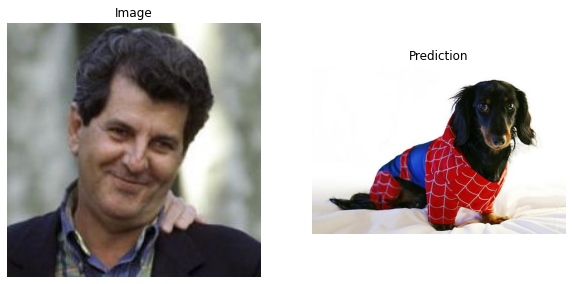

In [55]:
breed_estimator(human_files[28])

I think this dog is a: Plott



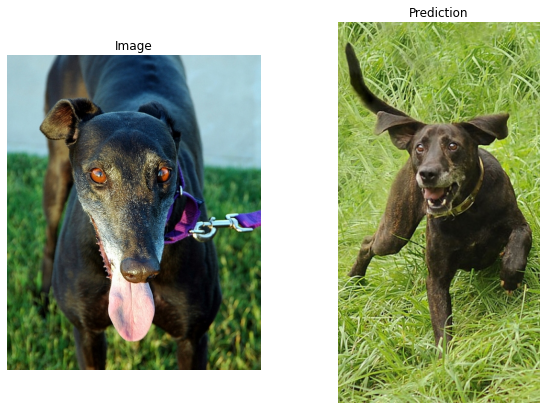

In [56]:
breed_estimator(test_files[40])

I think this dog is a: American staffordshire terrier



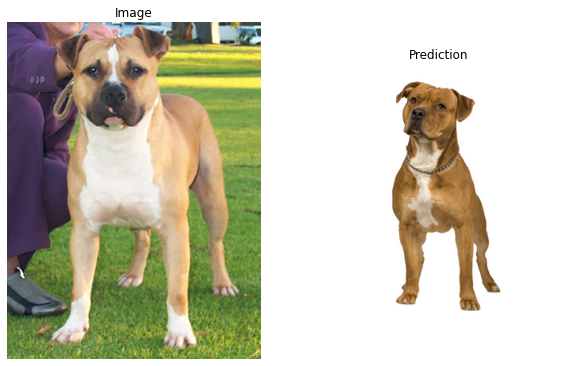

In [57]:
breed_estimator(test_files[100])

This human looks like a: Dachshund



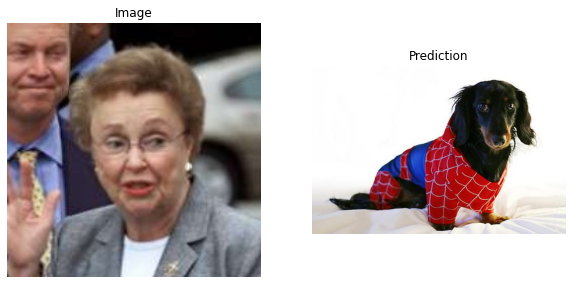

In [ ]:
breed_estimator(human_files[1087])

This human looks like a: Dachshund



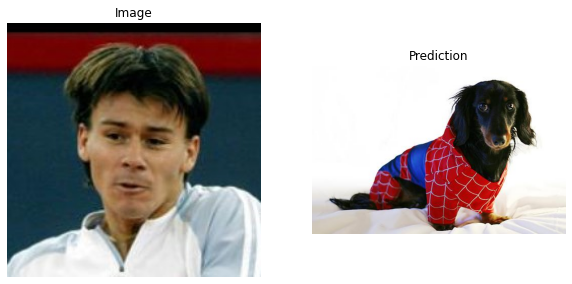

In [59]:
breed_estimator(human_files[1])

I think this dog is a: Maltese



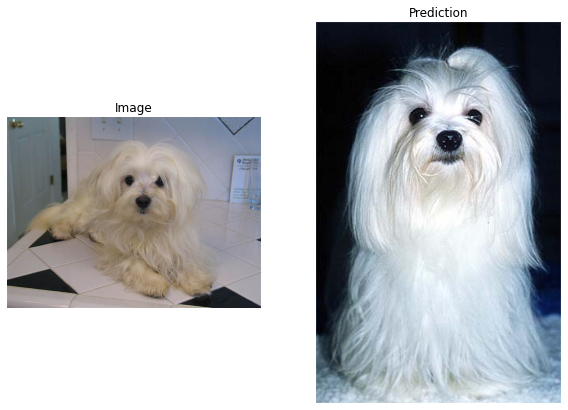

In [60]:
breed_estimator(test_files[72])

This human looks like a: Lowchen



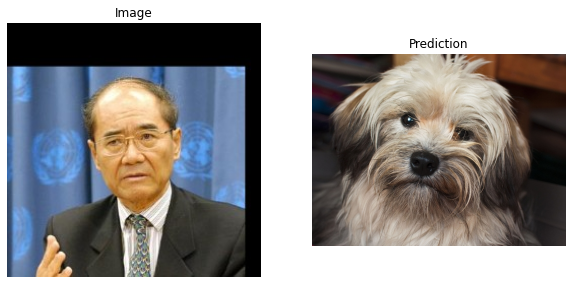

In [61]:
breed_estimator(human_files[252])